In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pdb

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import models, transforms

In [ ]:
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, scale=(1.0, 1.1), shear=0),      # zoom
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
batch_size = 128     # 32/64/128
data_dir = './drive/MyDrive/deep learn/project/dataset'   # change to your directory
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
val_size = int(0.2 * len(image_datasets['train']))
train_size = len(image_datasets['train']) - val_size
train_set, val_set = random_split(image_datasets['train'], [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=4)
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def set_parameter_requires_grad(model, feature_extracting=False):

  if feature_extracting:
      # frozen model
      model.requires_grad_(False)
  else:
      # fine-tuning
      model.requires_grad_(True)

In [ ]:
# for LoRA/DoRA
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        # rank: controls the inner dimension of the matrices A and B; controls the number of additional parameters introduced by LoRA,
        # a key factor in determining the balance between model adaptability and parameter efficiency.
        # alpha: a scaling hyper-parameter applied to the output of the low-rank adaptation,
        # controls the extent to which the adapted layer's output is allowed to influence the original output of the layer being adapted.

        self.use_dora = use_dora
        self.rank = rank  # low-rank
        self.alpha = alpha  # scaling hyper-parameter
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))

        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T
            return F.linear(x, combined_weight, self.linear.bias)

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True, DoRA=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0  # image size, e.g. (3, 224, 224)
    weights = 'DEFAULT' if use_pretrained else None
    if model_name == "mobile net 2":
        model_ft = models.mobilenet_v2(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        if DoRA:
            rank, alpha = 4, 8
            model_ft.classifier[0] = LowRankLayer(model_ft.classifier[0], rank, alpha, use_dora=True)
        num_ftrs = model_ft.classifier[1].in_features       # 1280
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)  # replace the last FC layer
        input_size = 224

    elif model_name == "mobile net 3 large":
        model_ft = models.mobilenet_v3_large(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        if DoRA:
            rank, alpha = 4, 8
            model_ft.classifier[0] = LowRankLayer(model_ft.classifier[0], rank, alpha, use_dora=True)
        num_ftrs = model_ft.classifier[3].in_features       # 1280
        model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "mobile net 3 small":
        model_ft = models.mobilenet_v3_small(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        if DoRA:
            rank, alpha = 4, 8
            model_ft.classifier[0] = LowRankLayer(model_ft.classifier[0], rank, alpha, use_dora=True)
        num_ftrs = model_ft.classifier[3].in_features       # 1024
        model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":  # just to show 1X1 convolutional replacement instead of fully connected
        model_ft = models.squeezenet1_0(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "resnet50":
        model_ft = models.resnet50(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vit base 16":       # visual transformer model
        model_ft = models.vit_b_16(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.heads[0].in_features
        model_ft.heads[0] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        raise NotImplementedError

    return model_ft, input_size

In [ ]:
MN_models = ["mobile net 2", "mobile net 3 small", "mobile net 3 large", "squeezenet", "resnet50", "vit base 16"]
model_name = MN_models[2]
num_classes = 2
num_epochs = 15
# Flag for feature extracting. When False, we fine-tune the whole model,
# when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True, DoRA=True)

# Print the model we just instantiated
# print(model_ft)

In [ ]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []  # override the initial list definition above
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.0.A
	 classifier.0.B
	 classifier.0.m
	 classifier.3.weight
	 classifier.3.bias


In [ ]:
# training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    model = model.to(device)

    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    history = [train_loss, train_acc, val_loss, val_acc]


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss.append(epoch_loss), train_acc.append(epoch_acc)

                # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss.append(epoch_loss), val_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, time_elapsed          # time in seconds




In [ ]:
# Setup the loss fn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, history, model_time = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.7282 Acc: 0.4479
val Loss: 0.7464 Acc: 0.5060

Epoch 1/14
----------
train Loss: 0.6961 Acc: 0.5476
val Loss: 0.6634 Acc: 0.5833

Epoch 2/14
----------
train Loss: 0.6830 Acc: 0.5417
val Loss: 0.6532 Acc: 0.6131

Epoch 3/14
----------
train Loss: 0.6586 Acc: 0.5923
val Loss: 0.6441 Acc: 0.5952

Epoch 4/14
----------
train Loss: 0.6444 Acc: 0.6190
val Loss: 0.6173 Acc: 0.6726

Epoch 5/14
----------
train Loss: 0.6283 Acc: 0.6295
val Loss: 0.6289 Acc: 0.6905

Epoch 6/14
----------
train Loss: 0.6186 Acc: 0.6562
val Loss: 0.6524 Acc: 0.6488

Epoch 7/14
----------
train Loss: 0.6215 Acc: 0.6518
val Loss: 0.6148 Acc: 0.6786

Epoch 8/14
----------
train Loss: 0.6094 Acc: 0.6741
val Loss: 0.6133 Acc: 0.6667

Epoch 9/14
----------
train Loss: 0.5828 Acc: 0.6860
val Loss: 0.6311 Acc: 0.6310

Epoch 10/14
----------
train Loss: 0.5844 Acc: 0.6935
val Loss: 0.6200 Acc: 0.6726

Epoch 11/14
----------
train Loss: 0.5758 Acc: 0.6920
val Loss: 0.5915 Acc: 0.7024

Ep

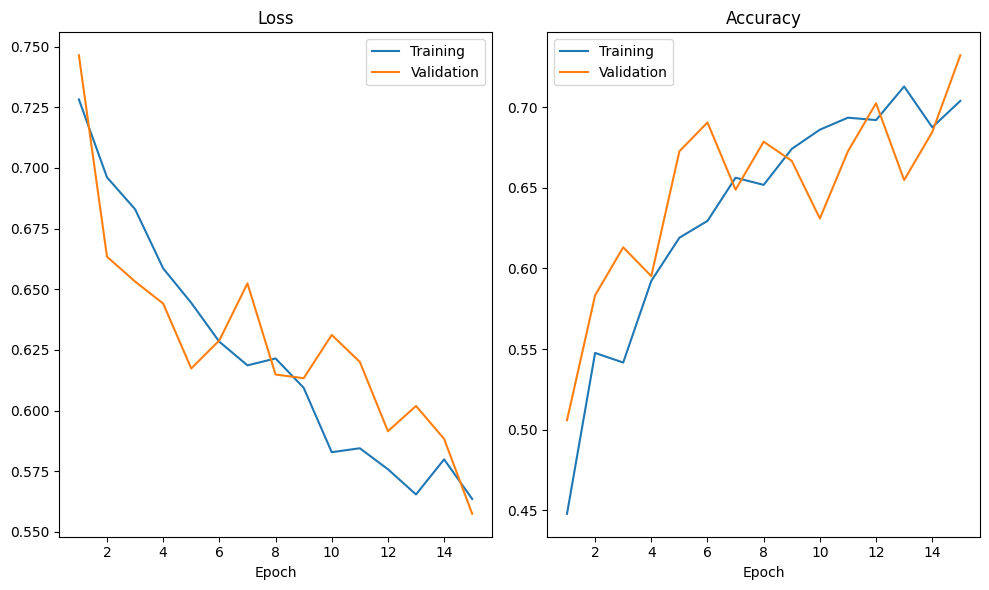

In [ ]:
# plot and save the best model
def plot_test_results(hist):

    epochs = len(hist[0])

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    axes[0].plot(range(1, epochs + 1), hist[0], label='Training')
    axes[0].plot(range(1, epochs + 1), hist[2], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_title('Loss')
    axes[0].legend(loc='best')


    axes[1].plot(range(1, epochs + 1), hist[1], label='Training')
    axes[1].plot(range(1, epochs + 1), hist[3], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_title('Accuracy')
    axes[1].legend(loc='best')

    plt.tight_layout()
    plt.show()

plot_test_results(history)

In [ ]:
model_save_dir = './drive/MyDrive/deep learn/project/CNN_models'      # change to your directory
model_save_name = 'model_MN3s_bz_128_ep_15_fe_DoRA.pth'
model_save_path = os.path.join(model_save_dir, model_save_name)
torch.save(model_ft.state_dict(), model_save_path)

In [ ]:
# load the best model
# error: datatype is 'Incompatible keys' although 'All keys matched successfully'. don't know why...
# so can't load saved results, only run again and use the currect results.
best_model, _ = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True, DoRA=False)
best_model = best_model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [ ]:
# testing function
def test_model(model, test_loader, criterion, optimizer, num_epochs=25):

    model = model.to(device)
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(test_loader.dataset)
    acc = running_corrects.double() / len(test_loader.dataset)

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(loss, acc))

    return loss, acc

In [ ]:
# Evaluate on the test set
best_model = model_ft
test_loss, test_acc = test_model(best_model, dataloaders['test'], criterion, optimizer_ft, num_epochs=num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.3763 Acc: 0.8936
